# Make figures

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import glob
import sys
from shapely import wkt
import seaborn as sns
import string
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
import ast
from matplotlib.patches import Rectangle
import matplotlib
import contextily as ctx
import rioxarray as rxr
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

# scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
scm_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/'
figures_out_path = os.path.join(base_path, 'figures')
eras_fn = os.path.join(scm_path, 'compiled_data', 'all_era_data.csv')
clusters_fn = os.path.join(scm_path, 'compiled_data', 'climate_clusters.csv')
snowlines_fn = os.path.join(scm_path, 'compiled_data', 'all_snowlines.csv')

## Define some colormaps

In [198]:
# Climate clusters
cluster_cmap_dict = {'W. Aleutians': '#dd3497', 
                     'Continental': '#a6611a',
                     'Transitional-Continental': '#dfc27d',
                     'Transitional-Maritime': '#80cdc1',
                     'Maritime': '#018571'}

subregions_cmap_dict = {'Brooks Range': 'c',
                        'Alaska Range': '#1f78b4',
                        'Aleutians': '#6d9c43',
                        'W. Chugach Mtns.': '#264708',
                        'St. Elias Mtns.': '#fb9a99',
                        'N. Coast Ranges': '#e31a1c',
                        'N. Rockies': '#cab2d6',
                        'N. Cascades': '#fdbf6f',
                        'C. Rockies': '#9657d9',
                        'S. Cascades': '#ff7f00',
                        'S. Rockies': '#6a3d9a'}

cmap = plt.cm.Greys
n = len(subregions_cmap_dict)
subregions_cmap_dict_grey = {'Alaska Range': cmap(0/n),
                             'Aleutians': cmap(1/n),
                             'W. Chugach Mtns.': cmap(2/n),
                             'St. Elias Mtns.': cmap(3/n),
                             'N. Coast Ranges': cmap(4/n),
                             'N. Rockies': cmap(5/n),
                             'N. Cascades': cmap(6/n),
                             'C. Rockies': cmap(7/n),
                             'S. Cascades': cmap(8/n),
                             'S. Rockies': cmap(9/n)}

## Define order of clusters and subregions for plotting

In [4]:
cluster_order = ['W. Aleutians', 'Maritime', 'Transitional-Maritime', 'Transitional-Continental', 'Continental']
subregion_order = ['Aleutians', 'Alaska Range', 'W. Chugach Mtns.', 'St. Elias Mtns.', 'N. Rockies', 
                   'N. Coast Ranges', 'C. Rockies', 'N. Cascades', 'S. Rockies', 'S. Cascades']
# separate subregions for plotting
group1 = ['Aleutians', 'N. Coast Ranges', 'W. Chugach Mtns.', 'N. Cascades', 'S. Cascades']
group2 = ['Alaska Range', 'St. Elias Mtns.', 'N. Rockies', 'C. Rockies', 'S. Rockies']

## Figure 1. Median AARs map and boxplots

In [ ]:
# -----Define CRS
crs = 'EPSG:4326'

# -----Load glacier boundaries (AOIs)
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
# Add subregion name and color
aois[['Subregion', 'color']] = '', ''
for o1, o2 in aois[['O1Region', 'O2Region']].drop_duplicates().values:
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2), 'Subregion'] = subregion_name
    aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2), 'color'] = color
# reproject
aois_reproj = aois.to_crs(crs)
aois_reproj['centroid'] = [x.centroid for x in aois_reproj['geometry']]
aois_reproj['centroid_x'] = [x.coords.xy[0][0] for x in aois_reproj['centroid']]
aois_reproj['centroid_y'] = [x.coords.xy[1][0] for x in aois_reproj['centroid']]
print('All glacier boundaries loaded from file.')

# -----Load RGI O2 Regions
rgi_O2_fn = os.path.join(scm_path, '..', 'GIS_data', 'RGI', 'RGIv7_02Regions', 
                                'RGI2000-v7.0-o2regions-Alaska-westernCanadaUS_clipped_to_country_outlines.shp')
rgi_O2 = gpd.read_file(rgi_O2_fn)
# remove Brooks Range
rgi_O2 = rgi_O2.loc[rgi_O2['o2region']!='01-01']
# add subregion name and color column
rgi_O2[['Subregion', 'color']] = '', ''
for o1o2 in rgi_O2['o2region'].drop_duplicates().values:
    o1 = int(o1o2[0:2])
    o2 = int(o1o2[3:])
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    rgi_O2.loc[rgi_O2['o2region']==o1o2, 'Subregion'] = subregion_name
    rgi_O2.loc[rgi_O2['o2region']==o1o2, 'color'] = color
# reproject
rgi_O2_reproj = rgi_O2.to_crs(crs)
print('RGI O2 regions loaded from file')

# -----Load GTOPO30
gtopo_fn = '/Users/raineyaberle/Research/PhD/GIS_data/GTOPO30_clip.tif'
gtopo = rxr.open_rasterio(gtopo_fn)
gtopo = xr.where(gtopo==-32768, np.nan, gtopo)
print('GTOPO30 loaded from file')

# -----Load mean weather conditions
mean_climate_fn = os.path.join(scm_path, 'compiled_data', 'climate_clusters.csv')
mean_climate = pd.read_csv(mean_climate_fn)
# add order columns
aois['order'] = ''
mean_climate['order'] = ''
for i, clustName in enumerate(cluster_order):
    aois.loc[aois['clustName']==clustName, 'order'] = i
    mean_climate.loc[mean_climate['clustName']==clustName, 'order'] = i
# sort by order column
aois = aois.sort_values(by='order')
mean_climate = mean_climate.sort_values(by='order')
print('Mean weather conditions loaded from file')

# -----Load median AARs for all sites
min_snow_cover_stats_fn = os.path.join(scm_path, 'results', 'min_snow_cover_stats.csv')
min_snow_cover_stats = pd.read_csv(min_snow_cover_stats_fn)
# Add to AOIs
aois['median_AAR'] = np.nan
for site_name in min_snow_cover_stats['RGIId'].drop_duplicates().values:
    median_aar = min_snow_cover_stats.loc[min_snow_cover_stats['RGIId']==site_name, 'AAR_P50_min'].values[0]
    aois.loc[aois['RGIId']==site_name, 'median_AAR'] = median_aar
print('Median AARs loaded from file')

In [ ]:
# -----Set up figure
fontsize=14
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
gs1 = matplotlib.gridspec.GridSpec(4, 2, height_ratios=[2, 2, 1, 1], width_ratios=[2.5,1])
gs2 = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[2,1], wspace=0.3)

fig = plt.figure(figsize=(14,14))
ax = [fig.add_subplot(gs1[0:2,0]), fig.add_subplot(gs1[1,1]),
      fig.add_subplot(gs2[1,0]), fig.add_subplot(gs2[1,1])]

# GTOPO hillshade
ls = matplotlib.colors.LightSource(azdeg=90, altdeg=45)
ax[0].imshow(ls.hillshade(gtopo.data[0], vert_exag=0.002), cmap='gray', alpha=0.5,
             extent=(np.min(gtopo.x.data), np.max(gtopo.x.data), 
                     np.min(gtopo.y.data), np.max(gtopo.y.data)))
# RGI O2 region outlines
color = '#525252'
rgi_O2_reproj.plot(ax=ax[0], alpha=1.0, facecolor='None', edgecolor=color, linewidth=1.5)
# Study site locations
sns.scatterplot(data=aois, x='centroid_x', y='centroid_y', hue='clustName', size='median_AAR', sizes=(10,100),
                edgecolor='k', linewidth=1, palette=cluster_cmap_dict, ax=ax[0], legend=True)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend().remove()
labels = [x.replace('Area', 'Area [km$^2$]').replace('clustName', 'Climate class').replace('median_AAR', 'Median AAR') 
          for x in labels]
fig.legend(handles, labels, ncols=2, loc='center right', bbox_to_anchor=[0.74, 0.65, 0.2, 0.2])
ax[0].set_yticks(np.linspace(45, 65, num=6))
ax[0].set_xlim(-167, -112)
ax[0].set_ylim(45, 67)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_aspect(2.2)
ax[0].set_position(pos=[0.08, 0.418, 0.5, 0.43])
# Add region labels and arrows where necessary
fontsize = 10
fontweight = 'bold'
ax[0].text(-163, 56, 'Aleutians', color=color, rotation=35, fontsize=fontsize, fontweight=fontweight)
ax[0].text(-158, 62.3, 'Alaska Range', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
ax[0].text(-147.9, 57.8, 'W. Chugach \nMtns.', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
ax[0].arrow(-147.6, 58.8, 0, 0.8, color=color, linewidth=2, head_width=0.25, head_length=0.2)
ax[0].text(-141.7, 57.7, 'St. Elias \nMtns.', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
ax[0].arrow(-141.5, 58.7, 0, 0.8, color=color, linewidth=2, head_width=0.25, head_length=0.2)
ax[0].text(-139, 56.4, 'N. Coast \nRanges', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
ax[0].arrow(-137.3, 56.8, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
ax[0].text(-133, 51.3, 'N. Cascades', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
ax[0].arrow(-129.4, 51.4, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
ax[0].text(-129.7, 47, 'S. Cascades', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
ax[0].arrow(-126, 47.1, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
ax[0].text(-132, 64, 'N. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
ax[0].text(-122, 55, 'C. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
ax[0].text(-117.7, 47, 'S. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)

# Climate classes
sns.scatterplot(data=mean_climate, x='max_annual_temp_range_mean', y='max_annual_precip_mean', hue='clustName',
                s=20, edgecolor='None', linewidth=1, palette=cluster_cmap_dict, ax=ax[1], legend=False)
ax[1].grid()
ax[1].set_ylabel('Mean annual total precipitation [m.w.e.]')
ax[1].set_xlabel('Mean annual range in air temperature [$^{\circ}$C]')
ax[1].set_position([0.65, 0.42, 0.25, 0.25])
ax[1].spines[['right', 'top']].set_visible(False)

# Median AARs boxplots
for axis, group in zip(ax[2:], [group1, group2]):
    aois_group = aois.loc[aois['Subregion'].isin(group)]
    sns.boxplot(aois_group, x='median_AAR', y='Subregion', showfliers=False,
                hue='clustName', palette=cluster_cmap_dict, order=group, hue_order=cluster_order,
                boxprops=dict(linewidth=1), ax=axis)
    axis.get_legend().remove()
    axis.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-0.5, 9.5, step=1)))
    axis.yaxis.grid(True, which='minor')
    axis.set_ylabel('')
    axis.set_xlabel('Median AAR')
    axis.set_xlim(0, 1)

# add text labels
for axis, label in zip(ax, ['a', 'b', 'c', 'd']):
    if label=='a':
        xpos, ypos = 0.95, 0.92
    elif label=='b':
        xpos, ypos = 0.91, 0.9
    else:
        xpos, ypos = 0.93, 0.08
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0])*xpos + axis.get_xlim()[0],
              (axis.get_ylim()[1] - axis.get_ylim()[0])*ypos + axis.get_ylim()[0],
              label, fontsize=16, fontweight='bold', 
              bbox=dict(facecolor='w', edgecolor='k', pad=5))

plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'fig01_median_aars_map_boxplots.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Figure 2: ELA sensitivity to air temperature

In [138]:
# Load RGI O2 Regions
rgi_O2_fn = os.path.join(scm_path, '..', 'GIS_data', 'RGI', 'RGIv7_02Regions', 
                         'RGI2000-v7.0-o2regions-Alaska-westernCanadaUS_clipped_to_country_outlines.shp')
rgi_O2 = gpd.read_file(rgi_O2_fn)
# remove Brooks Range
rgi_O2 = rgi_O2.loc[rgi_O2['o2region']!='01-01']
# Add subregion name column
rgi_O2['Subregion'] = ''
for o2str in rgi_O2['o2region'].drop_duplicates().values:
    o1, o2 = float(o2str[0:2]), float(o2str[3:])
    subregion_name, _ = f.determine_subregion_name_color(o1, o2)
    rgi_O2.loc[rgi_O2['o2region']==o2str, 'Subregion'] = subregion_name

# Load remotely-sensed ELA coefficients
fits_obs_fn = os.path.join(scm_path, 'results', 'linear_fit_observed_monthly_ela_pdd_snowfall.csv')
fits_obs_df = pd.read_csv(fits_obs_fn)
# Add the centroid coordinates to each site
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
fits_obs_df['centroid_x'] = 0
fits_obs_df['centroid_y'] = 0
for rgi_id in fits_obs_df['RGIId'].drop_duplicates().values:
    centroid_x, centroid_y = aois.loc[aois['RGIId']==rgi_id, 'geometry'].values[0].centroid.coords.xy
    centroid_x, centroid_y = centroid_x[0], centroid_y[0]
    fits_obs_df.loc[fits_obs_df['RGIId']==rgi_id, 'centroid_x'] = [centroid_x]
    fits_obs_df.loc[fits_obs_df['RGIId']==rgi_id, 'centroid_y'] = [centroid_y]
# Sort by cluster order for plotting
fits_obs_df['clustName'] = pd.Categorical(fits_obs_df['clustName'], cluster_order)
fits_obs_df.sort_values(by='clustName', inplace=True)
fits_obs_df.reset_index(drop=True, inplace=True)

fits_obs_df

,coef_PDD_mean,coef_PDD_std,coef_PDD_median,coef_PDD_MAD,coef_snowfall_mean,coef_snowfall_std,coef_snowfall_median,coef_snowfall_MAD,score_mean,score_median,RGIId,O1Region,O2Region,Subregion,cluster,clustName,centroid_x,centroid_y
0,0.860901,0.218853,0.929493,0.237271,61.474651,464.747568,-36.439235,278.460307,0.231140,0.186283,RGI60-01.08412,1,3,Aleutians,4,W. Aleutians,-163.924811,54.740043
1,0.870754,0.215275,0.813904,0.163999,-178.543822,174.053128,-141.487919,62.603363,0.613554,0.590256,RGI60-01.08246,1,3,Aleutians,4,W. Aleutians,-159.949184,55.969420
2,0.559185,0.088962,0.527596,0.051450,-48.321012,74.195787,-66.959313,42.885135,0.611895,0.598990,RGI60-01.08248,1,3,Aleutians,4,W. Aleutians,-159.972786,55.928054
3,1.222565,0.133140,1.206248,0.086853,-471.871002,271.719624,-448.481381,309.039302,0.594103,0.604010,RGI60-01.08427,1,3,Aleutians,4,W. Aleutians,-163.613106,54.811648
4,0.560374,0.155871,0.539340,0.096609,-53.192284,116.263019,-54.338957,52.186065,0.527929,0.499164,RGI60-01.08262,1,3,Aleutians,4,W. Aleutians,-159.858312,55.990261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.581749,0.208719,0.679408,0.064812,496.946075,291.852630,406.398381,92.493197,0.477357,0.501505,RGI60-02.12437,2,3,C. Rockies,2,Continental,-117.366192,52.165654
189,0.531742,0.123126,0.548030,0.059836,359.273538,158.016008,313.979090,65.302518,0.548192,0.552725,RGI60-02.12441,2,3,C. Rockies,2,Continental,-117.284017,52.175447
190,0.425204,0.098478,0.393596,0.097848,60.313949,123.571788,-17.906508,45.960489,0.309093,0.331516,RGI60-02.12468,2,1,N. Rockies,2,Continental,-128.010879,62.111656
191,-0.049965,0.135005,0.002610,0.099921,739.762387,182.387223,695.070660,167.004951,0.474575,0.481295,RGI60-02.12684,2,1,N. Rockies,2,Continental,-127.204421,62.313644


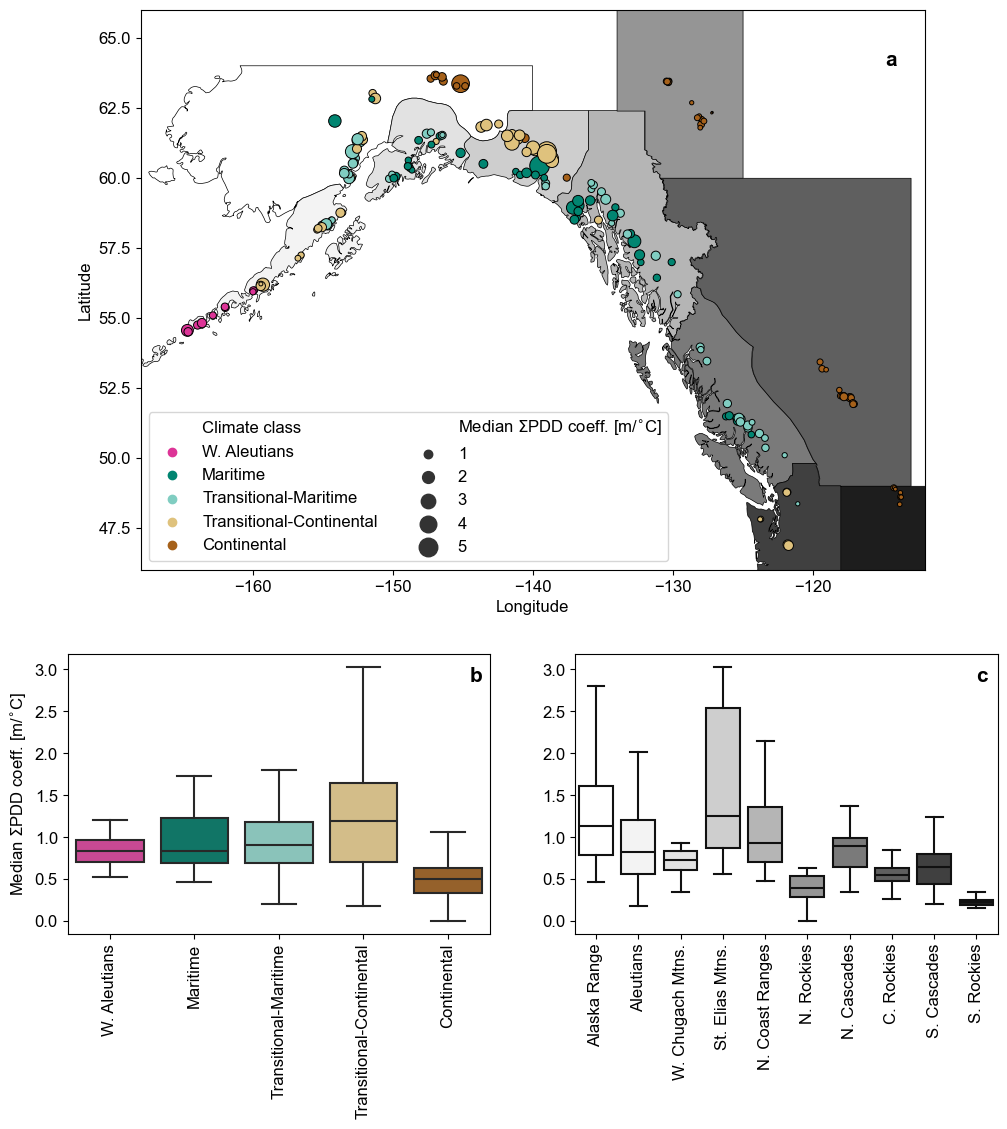

Figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/fig02_ELA_PDD_sensitivities.png


In [185]:
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[2,1])
ax = [fig.add_subplot(gs[0,:]),
      fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]

# Map view
# Subregion outlines
for subregion in rgi_O2['Subregion'].drop_duplicates().values:
    rgi_O2_subregion = rgi_O2.loc[rgi_O2['Subregion']==subregion]
    color = subregions_cmap_dict_grey[subregion]
    rgi_O2_subregion.plot(ax=ax[0], facecolor=color, edgecolor='k', linewidth=0.5)
sns.scatterplot(data=fits_obs_df, x='centroid_x', y='centroid_y', edgecolor='k', linewidth=0.7, 
                hue='clustName', palette=cluster_cmap_dict, size='coef_PDD_median', 
                sizes=(2,200), ax=ax[0])
handles, labels = ax[0].get_legend_handles_labels()
labels = [x.replace('clustName', 'Climate class').replace('coef_PDD_median', 'Median $\Sigma$PDD coeff. [m/$^{\circ}$C]') 
          for x in labels]
ax[0].legend(handles, labels, loc='lower left', bbox_to_anchor=[0.0, 0, 0.2, 0.2], ncols=2)
ax[0].set_xlim(-168, -112)
ax[0].set_ylim(46, 66)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_aspect(2)

# Box plots
sns.boxplot(data=fits_obs_df, x='clustName', y='coef_PDD_median', 
            hue='clustName', palette=cluster_cmap_dict, dodge=False, showfliers=False, ax=ax[1])
ax[1].legend().remove()
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_ylabel('Median $\Sigma$PDD coeff. [m/$^{\circ}$C]')
ax[1].set_xlabel('')
# Sort by subregions order for plotting
fits_obs_df['Subregion'] = pd.Categorical(fits_obs_df['Subregion'], list(subregions_cmap_dict_grey.keys()))
fits_obs_df.sort_values(by='Subregion', inplace=True)
fits_obs_df.reset_index(drop=True, inplace=True)
sns.boxplot(data=fits_obs_df, x='Subregion', y='coef_PDD_median', 
            hue='Subregion', palette=subregions_cmap_dict_grey, dodge=False, showfliers=False, ax=ax[2])
ax[2].legend().remove()
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].set_ylabel('')
ax[2].set_xlabel('')

# Add text labels
text_labels = ['a', 'b', 'c']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0])*0.95 + axis.get_xlim()[0],
              (axis.get_ylim()[1] - axis.get_ylim()[0])*0.9 + axis.get_ylim()[0],
              text_labels[i], fontsize=fontsize+3, fontweight='bold')

plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'fig02_ELA_PDD_sensitivities.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Figure 3. ELAs: observed/modeled comparison

In [235]:
# Determine whether to plot monthly or annual ELAs
temp_res = 'monthly'

# Load merged ELAs
if temp_res=='monthly':
    elas_merged_fn = os.path.join(scm_path, 'results', 'ELAs_monthly_mod_obs_merged.csv')
elif temp_res=='annual': 
    elas_merged_fn = os.path.join(scm_path, 'results', 'ELAs_annual_mod_obs_merged.csv')
elas_merged = pd.read_csv(elas_merged_fn)

# Add a difference column
elas_merged['ELA_obs_m-ELA_mod_m'] = elas_merged['ELA_obs_m'] - elas_merged['ELA_mod_m']

# AOIs
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
# Add subregion name and color
aois[['Subregion', 'color']] = '', ''
for o1, o2 in aois[['O1Region', 'O2Region']].drop_duplicates().values:
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2), 'Subregion'] = subregion_name
    aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2), 'color'] = color

# Add cluster name and subregion to each row
for rgi_id in elas_merged['RGIId'].drop_duplicates().values:
    subregion, cluster_name = aois.loc[aois['RGIId']==rgi_id, ['Subregion', 'clustName']].values[0]
    elas_merged.loc[elas_merged['RGIId']==rgi_id, ['Subregion', 'clustName']] = subregion, cluster_name

# Sort by cluster in correct order
elas_merged['clustName'] = pd.Categorical(elas_merged['clustName'], cluster_order)
elas_merged.sort_values(by='clustName', inplace=True)
elas_merged.reset_index(drop=True, inplace=True)

elas_merged

,RGIId,Date,ELA_mod_m,ELA_obs_m,ELA_obs_m-ELA_mod_m,Subregion,clustName
0,RGI60-01.08412,2019-08-01,131.635738,143.567132,11.931394,Aleutians,W. Aleutians
1,RGI60-01.08336,2018-05-01,0.000000,5.038050,5.038050,Aleutians,W. Aleutians
2,RGI60-01.08336,2018-06-01,0.000000,17.722140,17.722140,Aleutians,W. Aleutians
3,RGI60-01.08336,2018-08-01,172.234767,344.736470,172.501703,Aleutians,W. Aleutians
4,RGI60-01.08336,2018-09-01,345.772267,550.650620,204.878353,Aleutians,W. Aleutians
...,...,...,...,...,...,...,...
8994,RGI60-01.00038,2018-06-01,0.000000,636.035443,636.035443,Alaska Range,Continental
8995,RGI60-01.00038,2018-05-01,0.000000,321.932943,321.932943,Alaska Range,Continental
8996,RGI60-01.00038,2017-10-01,1479.556333,165.415443,-1314.140890,Alaska Range,Continental
8997,RGI60-02.12433,2019-05-01,0.000000,148.754580,148.754580,C. Rockies,Continental


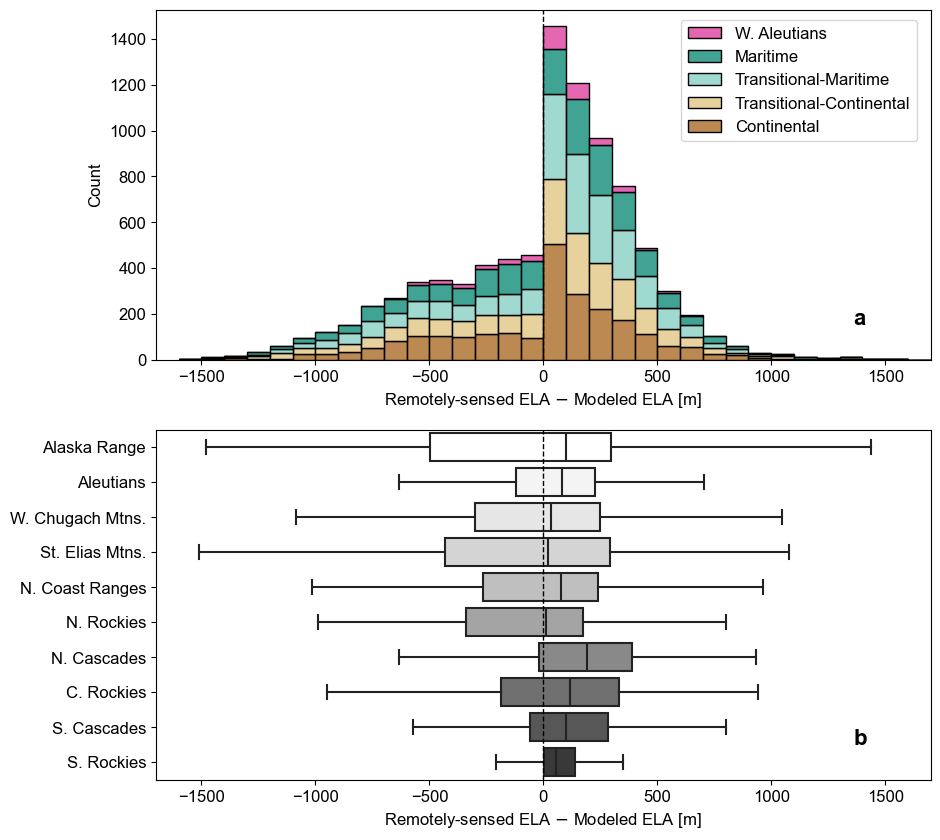

Figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/fig03_ELAs_observed_modeled_differences_monthly.png


In [236]:
# Plot
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# Define bins
bins_min = np.fix(elas_merged['ELA_obs_m-ELA_mod_m'].min() / 100) * 100
bins_max = np.round(elas_merged['ELA_obs_m-ELA_mod_m'].max() / 100) * 100
bins = np.arange(bins_min, bins_max, step=100)

# All regions histogram
sns.histplot(data=elas_merged, x='ELA_obs_m-ELA_mod_m', bins=bins, multiple='stack',
             hue='clustName', palette=cluster_cmap_dict, ax=ax[0])
sns.move_legend(ax[0], "lower center", bbox_to_anchor=(0.83, 0.6), title=None)
ax[0].set_xlabel('Remotely-sensed ELA $-$ Modeled ELA [m]')

# Subregion boxplots
# Sort by subregions order
elas_merged['Subregion'] = pd.Categorical(elas_merged['Subregion'], list(subregions_cmap_dict_grey.keys()))
elas_merged.sort_values(by='Subregion', inplace=True)
elas_merged.reset_index(drop=True, inplace=True)
sns.boxplot(data=elas_merged, x='ELA_obs_m-ELA_mod_m', y='Subregion', orient='h',
            color='Subregion', palette=subregions_cmap_dict_grey, ax=ax[1], showfliers=False)
ax[1].set_ylabel('')
ax[1].set_xlabel('Remotely-sensed ELA $-$ Modeled ELA [m]')

# Add text labels
text_labels = ['a', 'b']
for i, axis in enumerate(ax):
    axis.set_xlim(-1700, 1700)
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.9 + axis.get_xlim()[0],
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.1 + axis.get_ylim()[0],
              text_labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.axvline(0, linestyle='--', linewidth=1, color='k')

plt.show()

# Save figure
if temp_res=='monthly':
    fig_fn = os.path.join(figures_out_path, 'fig03_ELAs_observed_modeled_differences_monthly.png')
elif temp_res=='annual':
    fig_fn = os.path.join(figures_out_path, 'fig03_ELAs_observed_modeled_differences_annual.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Figure 4. ELA sensitivity to PDDs: observed/modeled comparison

In [ ]:
# Load linear fits for observed and modeled ELAs
fits_obs_fn = os.path.join(scm_path, 'results', 'linear_fit_observed_monthly_ela_pdd_snowfall.csv')
fits_obs_df = pd.read_csv(fits_obs_fn)
fits_mod_fn = os.path.join(scm_path, 'results', 'linear_fit_modeled_monthly_ela_pdd_snowfall.csv')
fits_mod_df = pd.read_csv(fits_mod_fn)

# Merge dataframes according to RGI ID
fits_merged_df = fits_mod_df.merge(fits_obs_df, 
                                   on=['RGIId', 'O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName'], 
                                   suffixes=['_mod', '_obs'])

# Remove wacky values
# for col in ['coef_PDD_mean_mod', 'coef_PDD_std_mod', 'coef_PDD_median_mod',
#        'coef_PDD_MAD_mod', 'coef_snowfall_mean_mod', 'coef_snowfall_std_mod',
#        'coef_snowfall_median_mod', 'coef_snowfall_MAD_mod', 'score_mean_mod',
#        'score_median_mod', 'coef_PDD_mean_obs', 'coef_PDD_std_obs',
#        'coef_PDD_median_obs', 'coef_PDD_MAD_obs', 'coef_snowfall_mean_obs',
#        'coef_snowfall_std_obs', 'coef_snowfall_median_obs',
#        'coef_snowfall_MAD_obs', 'score_mean_obs', 'score_median_obs']:
#     fits_merged_df.loc[np.abs(fits_merged_df[col]) > 1e33, col] = np.nan
    
# Add color for plotting
fits_merged_df['color'] = ''
for cluster_name, color in zip(list(cluster_cmap_dict.keys()), list(cluster_cmap_dict.values())):
    fits_merged_df.loc[fits_merged_df['clustName']==cluster_name, 'color'] = color
fits_merged_df

In [ ]:
# Determine whether to plot errorbars
error_bars = True
    
# Plot
plt.rcParams.update({'font.size':12, 'font.sans-serif': 'Arial'})
gs = matplotlib.gridspec.GridSpec(6, 2, height_ratios=[3, 1, 1, 1, 1, 1])
fig = plt.figure(figsize=(10,16))
ax = [fig.add_subplot(gs[0,:]),
      fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]),
      fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1]), 
      fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1]),
      fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1]),
      fig.add_subplot(gs[5,0]), fig.add_subplot(gs[5,1])]
text_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']

# one-to-one scatterplot
if error_bars:
    for x, y, xerr, yerr, color in zip(fits_merged_df['coef_PDD_median_mod'].values,
                                       fits_merged_df['coef_PDD_median_obs'].values,
                                       fits_merged_df['coef_PDD_MAD_mod'].values,
                                       fits_merged_df['coef_PDD_MAD_obs'].values,
                                       fits_merged_df['color'].values):
        ax[0].errorbar(x, y, xerr=xerr, yerr=yerr, color=color,
                       fmt='none', capsize=2)
# points
sns.scatterplot(data=fits_merged_df, x='coef_PDD_median_mod', y='coef_PDD_median_obs', 
                hue='clustName', palette=cluster_cmap_dict, ax=ax[0], legend=False)
ax[0].plot(np.arange(0, 10.1, step=0.5), np.arange(0, 10.1, step=0.5), '-k')
ax[0].set_title('a) All regions')
# annotations
# ax[0].arrow(1.75, 1.75, 0.05, -0.75, linewidth=1, linestyle='-', head_width=0.05, color='#737373')
# ax[0].arrow(1.75, 1.75, -0.05, 0.75, linewidth=1, linestyle='-', head_width=0.05, color='#737373')
# ax[0].text(1.7, 2.9, 'Observed ELAs more \n sensitive to air temp.', 
#            horizontalalignment='center', fontsize=12, color='#737373')
# ax[0].text(1.8, 0.3, 'Modeled ELAs more \n sensitive to air temp.', 
#            horizontalalignment='center', fontsize=12, color='#737373')
# ax[0].text(1.0, 1.1, '1:1', rotation=15, fontweight='bold')

# by subregion and climate class
for i, (axis, subregion) in enumerate(list(zip(ax[1:], [x for xs in list(zip(group1, group2)) for x in xs]))):
    fits_merged_df_subregion = fits_merged_df.loc[fits_merged_df['Subregion']==subregion]
    if error_bars:
        for x, y, xerr, yerr, color in zip(fits_merged_df_subregion['coef_PDD_median_mod'].values,
                                           fits_merged_df_subregion['coef_PDD_median_obs'].values,
                                           fits_merged_df_subregion['coef_PDD_MAD_mod'].values,
                                           fits_merged_df_subregion['coef_PDD_MAD_obs'].values,
                                           fits_merged_df_subregion['color'].values):
            axis.errorbar(x, y, xerr=xerr, yerr=yerr, color=color, fmt='none', capsize=2)
    sns.scatterplot(fits_merged_df_subregion, x='coef_PDD_median_mod', y='coef_PDD_median_obs', 
                    hue='clustName', palette=cluster_cmap_dict, hue_order=cluster_order, ax=axis)
    handles, labels = axis.get_legend_handles_labels()
    max_coef = np.nanmax([fits_merged_df_subregion['coef_PDD_median_mod'], 
                          fits_merged_df_subregion['coef_PDD_median_obs']])
                                                             
    axis.plot(np.arange(0, max_coef, step=0.1), np.arange(0, max_coef, step=0.1), '-k')
    axis.legend().remove()
    axis.set_title(text_labels[i+1] + ') ' + subregion)

fig.legend(handles, labels, ncol=5, loc='upper center', handletextpad=0.25, columnspacing=1, 
           bbox_to_anchor=[0.4, 0.73, 0.2, 0.2])

# Add axis labels
for i, axis in enumerate(ax):
    if (i==0) or (i>=9):
        axis.set_xlabel('Modeled ELA increase per PDD [m/PDD]')
    else:
        axis.set_xlabel('')
    if (i==0) or (i==5):
        axis.set_ylabel('Observed ELA increase per PDD [m/PDD]')
    else:
        axis.set_ylabel('')
    axis.grid()

fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Save figure
fig_fn = os.path.join(scm_path, 'snow-cover-mapping-application', 'figures', 
                      'fig03_ela_sensitivity_modeled_observed_monthly_comparison.png')
if error_bars:
    fig_fn = fig_fn.replace('_comparison.png', '_comparison_errorbars.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [ ]:
# Histograms of regression scores
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(2, 1, figsize=(10,8))
sns.histplot(data=fits_merged_df, x='score_mean_obs', multiple='stack', hue='clustName', ax=ax[0],
            palette=cluster_cmap_dict, legend=False, bins=np.linspace(0, 1, num=21))
ax[0].set_title('Observed')
# ax[0].set_xlim(0,1)
ax[0].set_xlabel('')
sns.histplot(data=fits_merged_df, x='score_mean_mod', multiple='stack', hue='clustName', ax=ax[1],
            palette=cluster_cmap_dict, bins=np.linspace(0, 1, num=21))
ax[1].set_title('Modeled')
# ax[1].set_xlim(0,1)
ax[1].set_xlabel('')

fig.suptitle('Regression scores')
plt.show()

In [ ]:
# Plot with colors distinguishing aspect

# Add Aspect and Aspect_bin columns
fits_merged_aspect_df = aois[['RGIId', 'Aspect']].merge(fits_merged_df, on='RGIId')
fits_merged_aspect_df['Aspect'] = fits_merged_aspect_df['Aspect'].astype(float)
fits_merged_aspect_df['Aspect_bin'] = pd.cut(fits_merged_aspect_df['Aspect'], np.arange(0,360,step=30))
    
# Plot
plt.rcParams.update({'font.size':12, 'font.sans-serif': 'Arial'})
gs = matplotlib.gridspec.GridSpec(6, 2, height_ratios=[3, 1, 1, 1, 1, 1])
fig = plt.figure(figsize=(12,16))
ax = [fig.add_subplot(gs[0,:]),
      fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]),
      fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1]),
      fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1]),
      fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1]),
      fig.add_subplot(gs[5,0]), fig.add_subplot(gs[5,1])]
text_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']

# one-to-one scatterplot
sns.scatterplot(data=fits_merged_aspect_df, x='coef_PDD_median_mod', y='coef_PDD_median_obs', 
                hue='Aspect_bin', palette='hls', ax=ax[0], legend=False)
max_coef = np.nanmax(np.ravel(fits_merged_df[['coef_PDD_median_mod', 'coef_PDD_median_obs']].values))
ax[0].plot(np.arange(0, max_coef), np.arange(0, max_coef), '-k')
ax[0].set_title('a) All regions')
# annotations
# ax[0].arrow(7, 7, 0.5, -2, linewidth=1, linestyle='--', head_width=0.2, color='k')
# ax[0].arrow(7, 7, -0.5, 2, linewidth=1, linestyle='--', head_width=0.2, color='k')
# ax[0].text(6, 10, 'Observed ELAs more \n sensitive to air temp.', 
#            horizontalalignment='center', fontsize=12)#, fontweight='bold')
# ax[0].text(8, 3, 'Modeled ELAs more \n sensitive to air temp.', 
#            horizontalalignment='center', fontsize=12)#, fontweight='bold')
# ax[0].text(10, 10.5, '1:1', rotation=20, fontweight='bold')

# differences boxplots by subregion and climate class
for i, (axis, subregion) in enumerate(list(zip(ax[1:], fits_merged_df['Subregion'].drop_duplicates().values))):
    fits_merged_aspect_df_subregion = fits_merged_aspect_df.loc[fits_merged_aspect_df['Subregion']==subregion]
    sns.scatterplot(fits_merged_aspect_df_subregion, x='coef_PDD_median_mod', y='coef_PDD_median_obs', 
                    hue='Aspect_bin', palette='hls', ax=axis)
    handles, labels = axis.get_legend_handles_labels()
    max_coef = np.nanmax([fits_merged_aspect_df_subregion['coef_PDD_median_mod'], 
                          fits_merged_aspect_df_subregion['coef_PDD_median_obs']])
                                                             
    axis.plot(np.arange(0, max_coef, step=0.1), np.arange(0, max_coef, step=0.1), '-k')
    axis.legend().remove()
    axis.set_title(text_labels[i+1] + ') ' + subregion)

fig.legend(handles, labels, ncol=4, loc='upper center', handletextpad=0.25, columnspacing=2, 
           bbox_to_anchor=[0.42, 0.76, 0.2, 0.2])

# Add axis labels
for i, axis in enumerate(ax):
    if (i==0) or (i>=9):
        axis.set_xlabel('Modeled ELA increase per PDD [m/PDD]')
    else:
        axis.set_xlabel('')
    if (i==0) or (i==5):
        axis.set_ylabel('Observed ELA increase per PDD [m/PDD]')
    else:
        axis.set_ylabel('')
    axis.grid()

fig.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

# Save figure
# fig_fn = os.path.join(scm_path, 'snow-cover-mapping-application', 'figures', 
#                       'fig05_ela_sensitivity_modeled_observed_comparison.png')
# fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)

## AAR time series

In [ ]:
# -----Add Year and WOY columns to snowlines
snowlines['Year'] = snowlines['datetime'].dt.isocalendar().year
snowlines['WOY'] = snowlines['datetime'].dt.isocalendar().week

# -----Add subregion and climate cluster columns to snowlines
snowlines[['Subregion', 'color']] = '', '', 
for o1, o2 in tqdm(aois[['O1Region', 'O2Region']].drop_duplicates().values):
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    aois_subregion = aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2)]
    site_names = aois_subregion['RGIId'].drop_duplicates().values
    for site_name in site_names:
        snowlines.loc[snowlines['site_name']==site_name, 'O1Region'] = o1
        snowlines.loc[snowlines['site_name']==site_name, 'O2Region'] = o2
        snowlines.loc[snowlines['site_name']==site_name, 'Subregion'] = subregion_name
        snowlines.loc[snowlines['site_name']==site_name, 'color'] = color
snowlines[['cluster', 'clustName']] = '', '', 
for site_name in (climate_clusters['site_name'].drop_duplicates().values):
    climate_clusters_site = climate_clusters.loc[climate_clusters['site_name']==site_name]
    snowlines.loc[snowlines['site_name']==site_name, 'cluster'] = climate_clusters_site['cluster'].values[0]
    snowlines.loc[snowlines['site_name']==site_name, 'clustName'] = climate_clusters_site['clustName'].values[0]
snowlines = snowlines.loc[snowlines['cluster']!='']
snowlines.reset_index(drop=True, inplace=True)

### By subregion

In [ ]:
# -----Set up figure
fig, ax = plt.subplots(10, 2, figsize=(12, 40), gridspec_kw={'width_ratios':[4,1]})
ax = ax.flatten()

def add_date_column(df):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + df['WOY'].astype(str) + '1', format='%Y%W%w')
    df['date'] = df['date'] - pd.Timedelta(days=1)
    return df

q1, q3 = 0.25, 0.75

# -----Iterate over subregions
o1o2s = snowlines[['O1Region', 'O2Region']].drop_duplicates().dropna().sort_values(by=['O1Region', 'O2Region']).values
ymin, ymax = -0.1, 1.1
for i, (o1, o2) in enumerate(o1o2s):
    # subset snowlines to subregion
    snowlines_subregion = snowlines.loc[(snowlines['O1Region']==o1) & (snowlines['O2Region']==o2)]
    if len(snowlines_subregion) < 1:
        continue
    subregion_name, color = snowlines_subregion[['Subregion', 'color']].values[0]
    if color=='':
        color='k'
    # calculate moving median over time
    ts_gb = snowlines_subregion.groupby(by=['Year', 'WOY'])['AAR']
    ts = ts_gb.median().reset_index()
    ts = add_date_column(ts)
    ts.rename(columns={'AAR': 'AAR_median'}, inplace=True)
    ts['AAR_Q1'] = ts_gb.quantile(q1).reset_index()['AAR']
    ts['AAR_Q3'] = ts_gb.quantile(q3).reset_index()['AAR']
    # calculate moving median for all years stacked
    weekly_gb = snowlines_subregion.groupby(by='WOY')['AAR']
    weekly = weekly_gb.median().reset_index()
    weekly.rename(columns={'AAR': 'AAR_median'}, inplace=True)
    weekly['AAR_Q1'] = weekly_gb.quantile(q1).reset_index()['AAR']
    weekly['AAR_Q3'] = weekly_gb.quantile(q3).reset_index()['AAR']
    weekly['WOY'] = weekly['WOY'].values.astype(float)
    # plot
    # add grey boxes where observations don't exist
    for year in ts['Year'].values:
        t1, t2 = pd.to_datetime(str(year-1)+'-11-01'), pd.to_datetime(str(year)+'-05-01')
        ax[i*2].add_patch(Rectangle((t1, ymin), width=t2-t1, height=ymax-ymin, facecolor='#d9d9d9', edgecolor='None'))
        ts_year = ts.loc[ts['Year']==year]
        ax[i*2].plot(ts_year['date'], ts_year['AAR_median'], 'o', color=color, linewidth=0.5, 
                     markerfacecolor=color, markeredgecolor='w', markersize=5)
    ax[i*2].set_ylim(ymin, ymax)
    ax[i*2].grid()
    ax[i*2].set_ylabel('AAR')
    N = len(snowlines_subregion['site_name'].drop_duplicates())
    ax[i*2].set_title(f'{subregion_name} (N={N})')
    ax[i*2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    ax[(i*2)+1].set_ylim(ymin, ymax)
    ax[(i*2)+1].grid()
    ax[(i*2)+1].fill_between(weekly['WOY'], weekly['AAR_Q1'], weekly['AAR_Q3'], color=color, alpha=0.5)
    ax[(i*2)+1].plot(weekly['WOY'], weekly['AAR_median'], '-', linewidth=2, color=color)
    # change week numbers to month labels
    ax[(i*2)+1].set_xticks([22, 31, 40])
    ax[(i*2)+1].set_xticklabels(['June', 'Aug', 'Oct'])

fig.subplots_adjust(hspace=0.3)
plt.show()

# -----Save figure
fig_fn = os.path.join(figures_out_path, 'timeseries_aar_subregions.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file:', fig_fn)

### By climate cluster

In [ ]:
# -----Set up figure
n_clusters = len(snowlines['cluster'].drop_duplicates().values)
fig, ax = plt.subplots(n_clusters, 2, figsize=(12, 4*n_clusters), gridspec_kw={'width_ratios':[4,1]})
ax = ax.flatten()

def add_date_column(df):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + df['WOY'].astype(str) + '1', format='%Y%W%w')
    df['date'] = df['date'] - pd.Timedelta(days=1)
    return df

q1, q3 = 0.25, 0.75

# -----Iterate over subregions
ymin, ymax = -0.1, 1.1
for i, cluster_name in enumerate(['Oceanic', 
                                  'Continental', 
                                  'Transitional-Continental', 
                                  'Transitional-Temperate', 
                                  'Temperate']):
    # subset snowlines to cluster
    snowlines_cluster = snowlines.loc[snowlines['clustName']==cluster_name]
    if len(snowlines_cluster) < 1:
        continue
    # grab cluster name
    color = cluster_cmap_dict[cluster_name]
    # calculate moving median over time
    ts_gb = snowlines_cluster.groupby(by=['Year', 'WOY'])['AAR']
    ts = ts_gb.median().reset_index()
    ts = add_date_column(ts)
    ts.rename(columns={'AAR': 'AAR_median'}, inplace=True)
    ts['AAR_Q1'] = ts_gb.quantile(q1).reset_index()['AAR']
    ts['AAR_Q3'] = ts_gb.quantile(q3).reset_index()['AAR']
    # calculate moving median for all years stacked
    weekly_gb = snowlines_cluster.groupby(by='WOY')['AAR']
    weekly = weekly_gb.median().reset_index()
    weekly.rename(columns={'AAR': 'AAR_median'}, inplace=True)
    weekly['AAR_Q1'] = weekly_gb.quantile(q1).reset_index()['AAR']
    weekly['AAR_Q3'] = weekly_gb.quantile(q3).reset_index()['AAR']
    weekly['WOY'] = weekly['WOY'].values.astype(float)
    # plot
    # add grey boxes where observations don't exist
    for year in ts['Year'].values:
        t1, t2 = pd.to_datetime(str(year-1)+'-11-01'), pd.to_datetime(str(year)+'-05-01')
        ax[i*2].add_patch(Rectangle((t1, ymin), width=t2-t1, height=ymax-ymin, facecolor='#d9d9d9', edgecolor='None'))
        ts_year = ts.loc[ts['Year']==year]
        ax[i*2].plot(ts_year['date'], ts_year['AAR_median'], 'o', color=color, linewidth=0.5, 
                     markerfacecolor=color, markeredgecolor='w', markersize=5)
    ax[i*2].set_ylim(ymin, ymax)
    ax[i*2].grid()
    ax[i*2].set_ylabel('AAR')
    N = len(snowlines_cluster['site_name'].drop_duplicates())
    ax[i*2].set_title(f'{cluster_name} (N={N})')
    ax[i*2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    ax[(i*2)+1].set_ylim(ymin, ymax)
    ax[(i*2)+1].grid()
    ax[(i*2)+1].fill_between(weekly['WOY'], weekly['AAR_Q1'], weekly['AAR_Q3'], color=color, alpha=0.5)
    ax[(i*2)+1].plot(weekly['WOY'], weekly['AAR_median'], '-', linewidth=2, color=color)
    # change week numbers to month labels
    ax[(i*2)+1].set_xticks([22, 31, 40])
    ax[(i*2)+1].set_xticklabels(['June', 'Aug', 'Oct'])

fig.subplots_adjust(hspace=0.3)
plt.show()

# -----Save figure
fig_fn = os.path.join(figures_out_path, 'timeseries_aar_clusters.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file:', fig_fn)

### Annual trends stacked

In [ ]:
# -----Set up figure
fig, ax = plt.subplots(2, 5, figsize=(14, 8))
ax = ax.flatten()

def add_date_column(df):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + df['WOY'].astype(str) + '1', format='%Y%W%w')
    df['date'] = df['date'] - pd.Timedelta(days=1)
    return df

cmap = plt.cm.viridis
    
# -----Iterate over subregions
o1o2s = snowlines[['O1Region', 'O2Region']].drop_duplicates().dropna().sort_values(by=['O1Region', 'O2Region']).values
ymin, ymax = -0.1, 1.1
for i, (o1, o2) in enumerate(o1o2s):
    # subset snowlines to subregion
    snowlines_subregion = snowlines.loc[(snowlines['O1Region']==o1) & (snowlines['O2Region']==o2)]
    if len(snowlines_subregion) < 1:
        continue
    subregion_name, color = snowlines_subregion[['Subregion', 'color']].values[0]
    if color=='':
        color='k'
    # calculate moving median for all years separately
    yearly_gb = snowlines_subregion.groupby(by=['Year', 'WOY'])['AAR']
    yearly = yearly_gb.median().reset_index()
    yearly.rename(columns={'AAR': 'AAR_median'}, inplace=True)
    # plot
    for year in yearly['Year'].drop_duplicates().values:
        yearly_year = yearly.loc[yearly['Year']==year]
        ax[i].plot(yearly_year['WOY'], yearly_year['AAR_median'], '-', color=cmap((year-2013)/(2023-2013)), linewidth=1)
    ax[i].set_ylim(ymin, ymax)
    ax[i].grid()
    if (i==0) or (i==5):
        ax[i].set_ylabel('AAR')
    else:
        ax[i].set_yticklabels([])
    if i < 5:
        ax[i].set_xticklabels([])
    N = len(snowlines_subregion['site_name'].drop_duplicates())
    ax[i].set_title(f'{subregion_name} (N={N})')

cbar_ax = fig.add_axes([0.94, 0.4, 0.01, 0.3])
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(2013, 2023), cmap=cmap),
             cax=cbar_ax, orientation='vertical')
fig.subplots_adjust(hspace=0.2)
plt.show()

# -----Save figure
fig_fn = os.path.join(figures_out_path, 'timeseries_aar_years_stacked.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file:', fig_fn)

### Weather data

In [ ]:
# -----Load ERA data
era_fn = os.path.join(scm_path, 'all_ERA_data', 'all_era_data.csv')
era = pd.read_csv(era_fn)
era['Date'] = pd.to_datetime(era['Date'])
# Add Year and WOY columns
era['Year'] = era['Date'].dt.isocalendar().year
era['WOY'] = era['Date'].dt.isocalendar().week

# -----Load AOIs
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)

# -----Add o1 and o2 region columns
era[['O1Region', 'O2Region']] = '', ''
for site_name in tqdm(era['site_name'].drop_duplicates().values):
    aoi = aois.loc[aois['RGIId']==site_name]
    o1, o2 = aoi[['O1Region', 'O2Region']].values[0]
    era.loc[era['site_name']==site_name, 'O1Region'] = o1
    era.loc[era['site_name']==site_name, 'O2Region'] = o2
era

In [ ]:
# -----Set up figure
plt.rcParams.update({'font.sans-serif':'Arial', 'font.size':12})
fig, ax = plt.subplots(10, 2, figsize=(14, 35), gridspec_kw={'width_ratios':[4,1]})
ax = ax.flatten()
ymin1, ymax1 = 0, 1.05
ymin2, ymax2 = 0, 1600
ymin3, ymax3 = 0, 4

weather_columns = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']
colors = ['#f4a582', '#2166ac']
q1, q3 = 0.25, 0.75

def add_date_column(df):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + df['WOY'].astype(str) + '1', format='%Y%W%w')
    df['date'] = df['date'] - pd.Timedelta(days=1)
    return df

def calculate_weekly_trends(df, column):
    ts_gb = df.groupby(by=['Year', 'WOY'])[column]
    ts = ts_gb.median().reset_index()
    ts = add_date_column(ts)
    ts.rename(columns={column: column+'_median'}, inplace=True)
    ts[column+'_Q1'] = ts_gb.quantile(q1).reset_index()[column]
    ts[column+'_Q3'] = ts_gb.quantile(q3).reset_index()[column]
    # calculate moving median for all years stacked
    weekly_gb = df.groupby(by='WOY')[column]
    weekly = weekly_gb.median().reset_index()
    weekly.rename(columns={column: column+'_median'}, inplace=True)
    weekly[column+'_Q1'] = weekly_gb.quantile(q1).reset_index()[column]
    weekly[column+'_Q3'] = weekly_gb.quantile(q3).reset_index()[column]

    return ts, weekly    

# -----Iterate over subregions
for i, (o1, o2) in enumerate(era[['O1Region', 'O2Region']].drop_duplicates().values):
    
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    print(subregion_name)
    
    # subset snowlines and ERA to subregion
    era_subregion = era.loc[(era['O1Region']==o1) & (era['O2Region']==o2)]
    snowlines_subregion = snowlines.loc[(snowlines['O1Region']==o1) & (snowlines['O2Region']==o2)]

    # calculate moving medians over time and plot
    # PDDs
    column, color = weather_columns[0], colors[0]
    ts, weekly = calculate_weekly_trends(era_subregion, column)
    for year in ts['Year'].drop_duplicates().values + 1:
        t1, t2 = pd.to_datetime(str(year-1)+'-11-01'), pd.to_datetime(str(year)+'-05-01')
        ax[i*2].add_patch(Rectangle((t1, ymin1), width=t2-t1, height=ymax1-ymin1, 
                                    facecolor='#d9d9d9', edgecolor='None', zorder=1))
    twin1 = ax[i*2].twinx()
    twin1.fill_between(ts['date'], ts[column+'_median'], np.zeros(len(ts)), 
                       facecolor=color, alpha=0.5, zorder=2)
    twin1.set_ylabel('$\Sigma$PDDs', color=color)
    twin1.spines['left'].set_color(color)
    twin1.tick_params(axis='y', colors=color)
    twin1.set_ylim(ymin2, ymax2)
    # Snowfall
    twin2 = ax[i*2].twinx()
    column, color = weather_columns[1], colors[1]
    ts, weekly = calculate_weekly_trends(era_subregion, column)
    twin2.plot(ts['date'], ts[column+'_median'], '-', color=color, linewidth=2, zorder=3)
    twin2.set_ylabel('$\Sigma$Snowfall [m.w.e.]', color=color)
    twin2.spines.right.set_color(color)
    twin2.spines.right.set_position(("axes", 1.1))
    twin2.tick_params(axis='y', colors=color)
    twin2.set_ylim(ymin3, ymax3)
    # AAR
    column, color = 'AAR', 'k'
    ts, weekly = calculate_weekly_trends(snowlines_subregion, column)
    ax[i*2].set_ylim(ymin1, ymax1)
    ax[i*2].plot(ts['date'], ts[column+'_median'], '.', color=color, markersize=7, zorder=5)
    ax[i*2].set_ylabel('AAR', color=color)
    ax[(i*2)+1].plot(weekly['WOY'], weekly[column+'_Q1'], '-', linewidth=1, color=color, alpha=0.5)
    ax[(i*2)+1].plot(weekly['WOY'], weekly[column+'_Q3'], '-', linewidth=1, color=color, alpha=0.5)
    ax[(i*2)+1].plot(weekly['WOY'], weekly[column+'_median'], '-', linewidth=2, color=color)
    ax[(i*2)+1].set_ylim(ymin1, ymax1)
    # adjust axes
    N = len(era_subregion['site_name'].drop_duplicates())
    ax[i*2].set_title(f'{subregion_name} (N={N})')
    ax[i*2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    ax[i*2].set_xlim(np.datetime64('2013-01-01'), np.datetime64('2024-02-01'))
    ax[(i*2)+1].grid()

fig.subplots_adjust(hspace=0.25, wspace=0.4)
plt.show()

# -----Save figure
fig_fn = os.path.join(figures_out_path, 'timeseries_aar_pdd_snowfall.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file:', fig_fn)

## Example AAR time series

In [ ]:
import json

In [ ]:
rgi_id = 'RGI60-02.18778'
data_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/' + rgi_id
out_path = os.path.join(scm_path, rgi_id + '_AAR_ELA_timeseries')

# Load snow cover stats and aois for site
aoi_fn = glob.glob(os.path.join(data_path, 'AOIs', '*.shp'))[0]
aoi = gpd.read_file(aoi_fn)
im_classified_fns = sorted(glob.glob(os.path.join(data_path, 'imagery', 'classified', '*.nc')))
sc_fn = os.path.join(data_path, rgi_id + '_snow_cover_stats.csv')
sc = pd.read_csv(sc_fn)
sc['datetime'] = pd.to_datetime(sc['datetime'])

# Load dataset dictionary for classified image colors
dataset_dict_fn = os.path.join(scm_path, 'snow-cover-mapping', 'inputs-outputs', 'datasets_characteristics.json')
with open(dataset_dict_fn) as f: 
    dataset_dict = json.loads(f.read()) 
colors = list(dataset_dict['classified_image']['class_colors'].values())
cmp = matplotlib.colors.ListedColormap(colors)
cmp

In [ ]:
sc['Year'] = pd.DatetimeIndex(sc['datetime']).year
Iyear = list(np.ravel(np.argwhere(sc['Year']==2018)))

aars, elas, times = [], [], []
for i in Iyear:
    date = str(sc.loc[i, 'datetime']).replace('-', '').replace(' ', 'T').replace(':','')
    dataset = sc.loc[i, 'dataset']
    if dataset=='PlanetScope':
        continue
    aars.append(sc.loc[i, 'AAR'])
    elas.append(sc.loc[i, 'ELA_from_AAR_m'])
    times.append(sc.loc[i, 'datetime'])
    print(date, dataset)
    im_classified_fn = [x for x in im_classified_fns if (date in os.path.basename(x)) & (dataset in os.path.basename(x))]
    if len(im_classified_fn) > 0:
        im_classified = xr.open_dataset(im_classified_fn[0])
        im_classified = im_classified.rio.reproject('EPSG:'+str(aoi.crs.to_epsg()))
        im_classified = xr.where(im_classified==float(im_classified.attrs['NoDataValues']), np.nan, im_classified)
    else:
        continue
    # plot
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 2]}, figsize=(10,5))
    ax[0].imshow(im_classified.classified.data[0], cmap=cmp, clim=(1,5),
                 extent=(np.min(im_classified.x.data), np.max(im_classified.x.data),
                         np.min(im_classified.y.data), np.max(im_classified.y.data)))
    aoi.plot(ax=ax[0], facecolor='None', edgecolor='k')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].plot(times, aars, '.b')
    ax[1].set_xlim(np.datetime64('2018-04-30'), np.datetime64('2018-11-01'))
    ax[1].set_ylim(0,1)
    ax[1].set_ylabel('AAR', color='b')
    ax[1].grid()
    ax2 = ax[1].twinx()
    ax2.plot(times, elas, '.g')
    ax2.set_ylim(np.nanmin(sc['ELA_from_AAR_m']), np.nanmax(sc['ELA_from_AAR_m']))
    ax2.set_ylabel('ELA [m]', color='g')
    fig.suptitle(f'{date} {dataset}')
    plt.show()

    fig_fn = os.path.join(out_path, f'{date}_{dataset}_{rgi_id}.png')
    fig.savefig(fig_fn, dpi=250)
    

## Figure X. AAR and weather time series

In [ ]:
# -----Load all snowlines
snowlines = pd.read_csv(snowlines_fn)
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
print('Snowlines loaded from file.')

# -----Load all ERA data
eras_fn = os.path.join(scm_path, 'compiled_data', 'all_era_data.csv')
eras = pd.read_csv(eras_fn)
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')
print('ERA loaded from file.')

# -----Load all AOIs
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
print('AOIs loaded from file.')


In [ ]:
# -----Plot median trends for each subregion
# add year and WOY columns to snowlines and ERA
snowlines['Year'] = snowlines['datetime'].dt.isocalendar().year
snowlines['WOY'] = snowlines['datetime'].dt.isocalendar().week
eras['Year'] = eras['Date'].dt.isocalendar().year
eras['WOY'] = eras['Date'].dt.isocalendar().week
# Set up figure
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': 12})
fig, ax = plt.subplots(5, 2, figsize=(12, 20), gridspec_kw={'width_ratios':[3,1]}, sharey=True)
ax = ax.flatten()
text_labels = list(string.ascii_lowercase[0:len(ax)])
# Iterate over clusters
for i, cluster in enumerate(cluster_order):
    
    # Grab all AOIs in cluster
    aois_cluster = aois.loc[aois['clustName']==cluster]
    site_names = aois_cluster['RGIId'].drop_duplicates().values
    # Grab all snowlines in subregion
    snowlines_cluster = snowlines.loc[snowlines['site_name'].isin(site_names)]
    # Calculate AAR median and IQR trends over time
    aar_yearly_median = snowlines_cluster.groupby(by=['Year', 'WOY'])['AAR'].median().reset_index()
    aar_yearly_median['deciyear'] = aar_yearly_median['Year'] + (aar_median['WOY'] / 52)
    aar_yearly_median.dropna(inplace=True)
    aar_weekly_median = snowlines_cluster.groupby(by='WOY')['AAR'].median()
    aar_weekly_Q1 = snowlines_cluster.groupby(by='WOY')['AAR'].quantile(q=0.25)
    aar_weekly_Q3 = snowlines_cluster.groupby(by='WOY')['AAR'].quantile(q=0.75)
    # Grab all ERA data in cluster
    eras_cluster = eras.loc[eras['site_name'].isin(site_names)]
    # Calculate PDD median trend over time
    pdd_median = eras_cluster.groupby(by=['Year', 'WOY'])['Cumulative_Positive_Degree_Days'].median().reset_index()
    pdd_median['deciyear'] = pdd_median['Year'] + (pdd_median['WOY'] / 52)
    # Calculate snowfall median trend over time
    snowfall_median = eras_cluster.groupby(by=['Year', 'WOY'])['Cumulative_Snowfall_mwe'].median().reset_index()
    snowfall_median['deciyear'] = snowfall_median['Year'] + (snowfall_median['WOY'] / 52)

    ### Plot
    ## Time series
    # PDDs
    ax2 = ax[i*2].twinx()
    ax2.fill_between(pdd_median['deciyear'].values.astype(float), 
                     np.zeros(len(pdd_median)), pdd_median['Cumulative_Positive_Degree_Days'], 
                     color='k', linewidth=0, zorder=1, alpha=0.4)
    ax2.set_ylabel('$\Sigma$PDD', color='grey')
    ax2.tick_params(axis='y', colors='grey')
    ax2.spines.right.set_color('grey')
    ax2.set_ylim(0, 1e3)
    # Snowfall
    # col = '#08519c'
    # ax3 = ax[i].twinx()
    # ax3.plot(snowfall_median['deciyear'], snowfall_median['Cumulative_Snowfall_mwe'], '-', color=col)
    # ax3.spines["right"].set_position(("axes", 1.15))
    # ax3.tick_params(axis='y', colors=col)
    # ax3.set_ylabel('$\Sigma$Snowfall [m.w.e.]', color=col)
    # ax3.spines.right.set_color(col)
    # AAR
    ax[i*2].plot(aar_yearly_median['deciyear'], aar_yearly_median['AAR'], 'o', 
               markerfacecolor=cluster_cmap_dict[cluster], markeredgecolor='k', alpha=1.0, linewidth=0.5, markersize=5, zorder=3)
    ax[i*2].grid()
    ax[i*2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[i*2].set_ylim(-0.1, 1.1)
    ax[i*2].set_ylabel('AAR')
    N = len(site_names)
    ax[i*2].set_title(f'{cluster} (N={N})')
    ax[i*2].text(2013, 0.05, text_labels[i*2], fontsize=14, fontweight='bold',
                 bbox=dict(facecolor='w', edgecolor='k', pad=5))

    ## Weekly median trends
    ax[i*2+1].fill_between(aar_weekly_Q1.index.values.astype(float), 
                           aar_weekly_Q1.values, aar_weekly_Q3.values, color=cluster_cmap_dict[cluster], alpha=0.5)
    ax[i*2+1].plot(aar_weekly_median.index.values.astype(float),
                   aar_weekly_median.values, '-', color=cluster_cmap_dict[cluster])
    ax[i*2+1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[i*2+1].grid()
    ax[i*2+1].text(21, 0.05, text_labels[i*2+1], fontsize=14, fontweight='bold',
                   bbox=dict(facecolor='w', edgecolor='k', pad=5))

fig.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

# -----Save figure
fig_fn = 'fig03_time_series_AAR_PDDs.png'
fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=200, bbox_inches='tight')
print('figure saved to file:', os.path.join(figures_out_path, fig_fn))


## Median AARs with different characteristics

In [ ]:
# -----Load minimum snow cover characteristics
min_snow_cover_stats_fn = os.path.join(scm_path, 'results', 'min_snow_cover_stats.csv')
min_snow_cover_stats = pd.read_csv(min_snow_cover_stats_fn)
min_snow_cover_stats['geometry'] = min_snow_cover_stats['geometry'].apply(wkt.loads)
# sort by region numbers
min_snow_cover_stats.sort_values(by=['O1Region', 'O2Region'], inplace=True)
# add cluster column
min_snow_cover_stats[['cluster', 'clustName']] = '', ''
for site_name in min_snow_cover_stats['RGIId'].drop_duplicates().values:
    clusters_site = clusters.loc[clusters['site_name']==site_name]
    min_snow_cover_stats.loc[min_snow_cover_stats['RGIId']==site_name, 'cluster'] = clusters_site['cluster'].values[0]
    min_snow_cover_stats.loc[min_snow_cover_stats['RGIId']==site_name, 'clustName'] = clusters_site['clustName'].values[0]

# add glacier boundary x and y centroid coordinates for plotting
min_snow_cover_stats['centroid_x'] = [x.centroid.coords.xy[0][0] for x in min_snow_cover_stats['geometry']]
min_snow_cover_stats['centroid_y'] = [x.centroid.coords.xy[1][0] for x in min_snow_cover_stats['geometry']]

# -----Load country outlines for plotting
countries_fn = os.path.join(scm_path, '..', 'GIS_data', 'countries_shp', 'countries.shp')
countries = gpd.read_file(countries_fn)
usca = countries.loc[(countries['NAME']=='United States') | (countries['NAME']=='Canada')].reset_index(drop=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# -----Plot maps of minimum AARs by various columns
columns = ['Subregion', 'clustName', 'Aspect', 'Zmed', 'Area', 'Slope']
columns_display = ['Subregion', 'Climate cluster', 'Aspect [degrees]', 'Median elevation [m]', 'Area [km$^2$]', 'Slope [degrees]']
palettes = [dict(min_snow_cover_stats[['Subregion', 'color']].drop_duplicates().values),
            cluster_cmap_dict,
            'hls', 
            'mako', 
            'viridis', 
            'crest']
bins_list = ['N/A', 
             'N/A',
             np.linspace(0,360, num=7), 
             np.linspace(500, 3000, num=6),
             np.linspace(0, 750, num=7),
             np.linspace(0, 35, num=8)]
plt.rcParams.update({'font.sans-serif':'Arial', 'font.size':12})
xmin, xmax = -168, -112
ymin, ymax = 45, 65
for column, column_display, palette, bins in zip(columns, columns_display, palettes, bins_list):
    fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios':[2.5, 1]})
    # plot country outlines on the map
    usca.plot(ax=ax[0], facecolor='None', edgecolor='grey')
    if column=='Subregion':
        # plot points on the map
        scatter = sns.scatterplot(data=min_snow_cover_stats, x='centroid_x', y='centroid_y', 
                                  hue=column, palette=palette, size='AAR_P50_min', 
                                  sizes=(5, 100), legend=True, ax=ax[0])
        # plot boxplots
        sns.boxplot(data=min_snow_cover_stats, x=column, y='AAR_P50_min', showfliers=False, palette=palette, ax=ax[1])
        ax[1].set_xticks(ax[1].get_xticks())
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
        # calculate number of obserations in each bin
        nobs = min_snow_cover_stats['Subregion'].value_counts().values
    elif column=='clustName':
        # plot points on the map
        scatter = sns.scatterplot(data=min_snow_cover_stats, x='centroid_x', y='centroid_y', 
                                  hue=column, palette=palette, size='AAR_P50_min', 
                                  sizes=(5, 100), legend=True, ax=ax[0])
        # plot boxplots
        sns.boxplot(data=min_snow_cover_stats, x=column, y='AAR_P50_min', showfliers=False, palette=palette, ax=ax[1])
        ax[1].set_xticks(ax[1].get_xticks())
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
        # calculate number of obserations in each bin
        nobs = min_snow_cover_stats['cluster'].value_counts().values
    else:
        # plot points on the map
        sns.scatterplot(data=min_snow_cover_stats, x='centroid_x', y='centroid_y', 
                        hue=column, size='AAR_P50_min', palette=palette,
                        sizes=(5, 100), legend=True, ax=ax[0])
        # add bin column
        min_snow_cover_stats[column + '_bin'] = pd.cut(min_snow_cover_stats[column], bins)
        # plot boxplots
        sns.boxplot(data=min_snow_cover_stats, x=column + '_bin', y='AAR_P50_min', showfliers=False, palette=palette, ax=ax[1])
        # calculate number of observations in each bin
        nobs = min_snow_cover_stats[column + '_bin'].value_counts().values
    # Add number of observations to the boxplot
    nobs = [str(x) for x in nobs.tolist()]
    pos = range(len(nobs))
    for tick in pos:
        ax[1].text(pos[tick], 1.0,
                   nobs[tick],
                   horizontalalignment='center',
                   color='k')
    # adjust legend and axes
    sns.move_legend(ax[0], "center right", bbox_to_anchor=[1.1, 0.4, 0.2, 0.2])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].grid()
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_xlabel(column_display)
    ax[1].set_ylim(0, 0.95)
    ax[1].set_ylabel('AAR')

    # Edit legend labels for map
    handles, labels = ax[0].get_legend_handles_labels()
    labels = [x.replace('AAR_P50_min', 'Median AAR').replace(column, column_display) for x in labels]
    ax[0].legend(handles, labels, loc='center right')
    if column=='clustName':
        anchor = [1.15, 0.4, 0.2, 0.2]
    else: 
        anchor = [1.1, 0.4, 0.2, 0.2]
    sns.move_legend(ax[0], "center right", bbox_to_anchor=anchor)
    
    plt.show()
    
    # Save figure
    fig_fn = 'aars_map_' + column + '.png'
    fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=250, bbox_inches='tight')
    print('figure saved to file: ', os.path.join(figures_out_path, fig_fn))

## Distribution of climates in each subregion

In [ ]:
# Add subregion names to aois
for o1, o2 in aois[['O1Region', 'O2Region']].drop_duplicates().values:
    subregion_name, color = f.determine_subregion_name_color(o1, o2)
    aois.loc[(aois['O1Region']==o1) & (aois['O2Region']==o2), 'Subregion'] = subregion_name

In [ ]:
# Group AOIs by Subregion and cluster to count values
grouped = aois.groupby(['Subregion', 'clustName']).size().unstack(fill_value=0)
# sort columns and indices
grouped = grouped[cluster_order]
grouped = grouped.reindex(subregion_order)
# subset into roughly coastal and not coastal groups
group1 = ['S. Cascades', 'N. Cascades', 'W. Chugach Mtns.', 'N. Coast Ranges', 'Aleutians']
grouped1 = grouped.loc[group1]
group2 = ['S. Rockies', 'C. Rockies', 'N. Rockies', 'St. Elias Mtns.', 'Alaska Range']
grouped2 = grouped.loc[group2]

# Plot stacked bar plot
fig, ax = plt.subplots(1, 2, figsize=(12,6))
grouped1.plot(kind='barh', stacked=True, legend=True,
              color=[cluster_cmap_dict.get(x, 'black') for x in grouped.columns], 
              ax=ax[0])
grouped2.plot(kind='barh', stacked=True, legend=False,
              color=[cluster_cmap_dict.get(x, 'black') for x in grouped.columns], 
              ax=ax[1])
ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('')
fig.suptitle('Distribution of climate classes within each Subregion')
# adjust legend
handles, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
fig.subplots_adjust(wspace=0.35)
fig.legend(handles, labels, title='Cluster', loc='upper right', bbox_to_anchor=[0.93, 0.4, 0.2, 0.2])
plt.show()

# Save to file
fig_fn = os.path.join(figures_out_path, 'subregions_clusters_distribution.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Plot linear changes in AARs for 2016-2023 by terrain characteristics

In [ ]:
# -----Load AARs linear fit
aars_linear_fit_fn = 'minimum_AARs_linear_fit.csv'
aars_linear_fit = pd.read_csv(os.path.join(snowlines_path, aars_linear_fit_fn))

# -----Add glacier terrain and geometry columns
columns = ['geometry', 'centroid_x', 'centroid_y', 'O1Region', 'O2Region', 'Subregion', 'color', 'Aspect', 'Slope', 'Zmed', 'Area']
for column in columns:
    aars_linear_fit[column] = np.nan
# iterate over site names
for site_name in aars_linear_fit['site_name'].drop_duplicates().values:
    min_snow_cover_stats_site = min_snow_cover_stats.loc[min_snow_cover_stats['RGIId']==site_name]
    try:
        for column in columns:
            aars_linear_fit.loc[aars_linear_fit['site_name']==site_name, column] = [min_snow_cover_stats_site[column].values[0]]
    except:
        continue

aars_linear_fit.dropna(inplace=True)

# -----Add column for negative value of change category to show more negative values as larger markers
aars_linear_fit['linear_fit_coef_neg'] = - aars_linear_fit['linear_fit_coef']
# Sort by region numbers
aars_linear_fit.sort_values(by=['O1Region', 'O2Region'], inplace=True)
aars_linear_fit

In [ ]:
# -----Plot map of AARs linear fit with various columns
columns = ['Subregion', 'Aspect', 'Zmed', 'Area', 'Slope']
columns_display = ['Subregion', 'Aspect [degrees]', 'Median elevation [m]', 'Area [km$^2$]', 'Slope [degrees]']
palettes = [dict(aars_linear_fit[['Subregion', 'color']].drop_duplicates().values),
            'hls', 
            'mako', 
            'viridis', 
            'crest']
bins_list = ['N/A', 
             np.linspace(0,360, num=7), 
             np.linspace(500, 3000, num=6),
             np.linspace(0, 750, num=7),
             np.linspace(0, 35, num=8)]
plt.rcParams.update({'font.sans-serif':'Arial', 'font.size':12})
xmin, xmax = -168, -112
ymin, ymax = 45, 65
def map_size(value):
    return np.abs(value) * 100
for column, column_display, palette, bins in zip(columns, columns_display, palettes, bins_list):
    fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios':[2.5, 1]})
    # plot country outlines on the map
    usca.plot(ax=ax[0], facecolor='None', edgecolor='grey')
    # plot points on the map
    if type(bins) != str:
        sns.scatterplot(data=aars_linear_fit, x='centroid_x', y='centroid_y', 
                        hue=column, palette=palette, size='linear_fit_coef_neg', sizes=(5, 150), legend=True, ax=ax[0])
    else:
        sns.scatterplot(data=aars_linear_fit, x='centroid_x', y='centroid_y', 
                        hue=column, palette=palette, size='linear_fit_coef_neg', sizes=(5, 150), legend=True, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].grid()
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    # plot regional barplots
    if type(bins) != str:
        # add bin column
        aars_linear_fit[column + '_bin'] = pd.cut(aars_linear_fit[column], bins)
        # plot boxplots
        sns.boxplot(data=aars_linear_fit, x=column + '_bin', y='linear_fit_coef', showfliers=False, palette=palette, ax=ax[1])
    else:
        # plot boxplots
        sns.boxplot(data=aars_linear_fit, x=column, y='linear_fit_coef', showfliers=False, palette=palette, ax=ax[1])
    if type(bins) == str:
        ax[1].set_xticks(ax[1].get_xticks())
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xlabel(column_display)
    ax[1].set_ylabel('AAR linear trend [per year]')
    
    # Edit legend labels for map
    handles, labels = ax[0].get_legend_handles_labels()
    labels = [x.replace('linear_fit_coef_neg', 'AAR linear trend [per year]').replace(column, column_display) for x in labels]
    labels = [x.replace('0.', '-0.').replace('−-0', '0') for x in labels]
    ax[0].legend(handles, labels, loc='center right')
    sns.move_legend(ax[0], "center right", bbox_to_anchor=[1.15, 0.4, 0.2, 0.2])

    plt.show()

    # Save figure
    fig_fn = 'AARs_linear_fit_map_' + column + '.png'
    fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=250, bbox_inches='tight')
    print('figure saved to file: ', os.path.join(figures_out_path, fig_fn))

## Plot AAR and linear fit time series for each site

In [ ]:
# Load snowlines
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
# Load minimum AAR fits
min_aars_fn = 'minimum_AARs_linear_fit.csv'
min_aars = pd.read_csv(os.path.join(snowlines_path, min_aars_fn))


In [ ]:
# Iterate over sites
for site_name in tqdm(min_aars['site_name'].drop_duplicates().values):
    # Grab snowlines
    snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
    # Grab min AARs
    min_aars_site = min_aars.loc[min_aars['site_name']==site_name].reset_index(drop=True)
    # Plot
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(snowlines_site['datetime'], snowlines_site['AAR'], '.k', markersize=1)
    ax.plot(min_aars_site['minimum_AARs_dts'], min_aars_site['minimum_AARs'], '*m', markersize=2)
    ax.grid()
    ax.set_title(site_name)
    plt.show()

In [ ]:
ast.literal_eval(min_aars['minimum_AARs'][0])#.apply(ast.literal_eval)

## Plot correlation statistics

### AAR-PDD correlations

In [ ]:
# -----Load AAR-PDD correlations for each subregion
corr_coeffs_fns = sorted(glob.glob(os.path.join(eras_path, 'correlation_*aar-pdd*.csv')))
corr_coeffs = pd.DataFrame()
for corr_coeffs_fn in corr_coeffs_fns:
    # grab subregion name from file name
    subregion_name = os.path.basename(corr_coeffs_fn).split('aar-pdd_')[1].split('.csv')[0]
    # load correlation coefficients for all sites
    corr_coeffs_subregion = pd.read_csv(corr_coeffs_fn)
    # add subregion name to dataframe
    corr_coeffs_subregion['Subregion'] = subregion_name    
    # concatenate to full dataframe
    corr_coeffs = pd.concat([corr_coeffs, corr_coeffs_subregion])
corr_coeffs

In [ ]:
# -----Plot boxplots
palette = dict(min_snow_cover_stats[['Subregion', 'color']].drop_duplicates().values)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=corr_coeffs, x='Subregion', y='AAR-PDD Corr. Coeff.', palette=palette, ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('AAR - $\Sigma$PDD Correlation Coefficients')
# ax.grid()
plt.show()

# -----Save to file
fig_fn = os.path.join(figures_out_path, 'aar-pdd_correlation_coefficients_boxplot.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file: ', fig_fn)

## Plot scatter plots of AAR vs. cumulative PDDs

In [ ]:
# -----Load all snowlines
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
snowlines['Date'] = snowlines['datetime'].values.astype('datetime64[D]')

# -----Load all ERA data
eras = pd.read_csv(os.path.join(eras_path, eras_fn))
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')

# -----Load all AOIs
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)

In [ ]:
# -----Fit multiple linear regression model to AAR, PDDs, and Snowfall
# intialize full dataframe
snowlines_eras_merged = pd.DataFrame()
# iterate over sites
for site_name in tqdm(snowlines['site_name'].drop_duplicates().values):
    # subset dataframes to site
    snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
    eras_site = eras.loc[eras['site_name']==site_name]
    # merge snowlines and ERA dataframes
    snowlines_eras_merged_site = snowlines_site.merge(eras_site, how='left', on='Date')
    snowlines_eras_merged_site.rename(columns={'site_name_x': 'site_name'}, inplace=True)
    # save in dataframe
    snowlines_eras_merged_site = snowlines_eras_merged_site[['site_name', 
                                                             'AAR', 
                                                             'Cumulative_Positive_Degree_Days',
                                                             'Cumulative_Precipitation_mwe',
                                                             'Cumulative_Snowfall_mwe']]
    snowlines_eras_merged_site.reset_index(drop=True, inplace=True)
    snowlines_eras_merged_site.dropna()
    # plot
    ax.plot(snowlines_eras_merged_site['Cumulative_Positive_Degree_Days'], 
            snowlines_eras_merged_site['AAR'], 
            '.', markersize=1)
    # concatenate to full dataframe
    snowlines_eras_merged = pd.concat([snowlines_eras_merged, snowlines_eras_merged_site])
    

In [ ]:
# -----Fit multi-linear regression model
snowlines_eras_merged.dropna(inplace=True)
model = LinearRegression()
X_columns = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']
# fit model
X = snowlines_eras_merged[X_columns]
y = snowlines_eras_merged['AAR'].values
model_fit = model.fit(X, y)
# calculate R^2
r2 = model_fit.score(X, y)
# plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(X[X_columns[0]], X[X_columns[1]], y, '.', color='grey', markersize=0.5)
y_pred = model_fit.predict(X)
ax.plot(X[X_columns[0]], X[X_columns[1]], y_pred, '.k')
ax.set_xlabel(X_columns[0])
ax.set_ylabel(X_columns[1])
ax.set_zlabel('AAR')
ax.set_title('AAR = ' + str(np.round(model_fit.coef_[0], 5)) + '*$\Sigma$PDDs ' 
             + str(np.round(model_fit.coef_[1], 5)) + '*$\Sigma$Snowfall' 
             + '\nR$^2$ = ' + str(np.round(r2,55)))
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'aar-pdd-snowfall_multiple_linear_regression.png')
fig.savefig(fig_fn, dpi=200, bbox_inches='tight')
print('figure saved to file:', fig_fn)

## Plot machine learning results

### Feature importances

## Climate/weather sensitivities

In [ ]:
# -----Define dictionary for colors of each subregion
color_dict = {
    'Brooks Range': 'c',
    'Alaska Range': '#1f78b4',
    'Aleutians': '#6d9c43',
    'W. Chugach Mtns.': '#264708',
    'St. Elias Mtns.': '#fb9a99',
    'N. Coast Ranges': '#e31a1c',
    'N. Rockies': '#cab2d6',
    'N. Cascades': '#fdbf6f',
    'C. Rockies': '#9657d9',
    'S. Cascades': '#ff7f00',
    'S. Rockies': '#6a3d9a'
}

In [ ]:
ml_path = os.path.join(scm_path, 'machine_learning')
sens_run_fns = sorted(glob.glob(os.path.join(ml_path, 'aar_sensitivity_tests*.csv')))

# -----Define regression model
model = LinearRegression()

# -----Set up figure
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'width_ratios': [3, 1]})
ax = ax.flatten()

# -----Iterate over PDDs and Snowfall
for i, column in enumerate(['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']):
    # Grab file names for column
    sens_run_column_fns = [x for x in sens_run_fns if column in x]
    # Iterate over file names
    for j, fn in enumerate(sens_run_column_fns):
        # grab subregion name from file name
        subregion_name = fn.split('aar_sensitivity_tests_')[1].split('_' + column)[0]
        color = color_dict[subregion_name]
        # load file
        sens_run = pd.read_csv(fn)
        # remove mean conditions row
        sens_run = sens_run.loc[sens_run['scenario']!='mean']
        # fit linear regression to cumsum(PDDs) and AAR
        model_fit = model.fit(sens_run[column].values.reshape(-1, 1), 
                              sens_run['AAR'].values.reshape(-1, 1))
        # grab linear fit coefficient
        coef = model_fit.coef_[0][0]
        # add to DataFrame
        fit_df = pd.DataFrame({'Subregion': [subregion_name],
                               'Color': color,
                               'Linear_Fit_Coefficient': [coef]})
        fits_df = pd.concat([fits_df, fit_df])
        # plot
        lines = ax[i*2].plot(sens_run[column], 
                             sens_run['AAR'], '-', label=subregion_name, color=color)
        ax[(i*2)+1].plot(j, coef, 'o', color=color, markersize=5, label=subregion_name)
    ax[i*2].set_ylabel('AAR')
    ax[i*2].set_xlabel(column)
    ax[i*2].grid()
    ax[(i*2)+1].set_ylabel('Linear fit coefficient')
    ax[(i*2)+1].grid()

leg = ax[1].legend(loc='right', bbox_to_anchor=[1.9, -0.2, 0.2, 0.2])
fig.subplots_adjust(wspace=0.3)
plt.show()


In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
model = BaggingRegressor()
model_fit = model.fit(sens_run[column].values.reshape(-1, 1), sens_run['AAR'].values.reshape(-1, 1))
model_fit

In [ ]:
# # -----Set up figure
# plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
# fig, ax0 = plt.subplots(1, 1, figsize=(14,12))

# # GTOPO hillshade
# ls = matplotlib.colors.LightSource(azdeg=90, altdeg=45)
# ax0.imshow(ls.hillshade(gtopo.data[0], vert_exag=0.002), cmap='gray', alpha=0.5,
#              extent=(np.min(gtopo.x.data), np.max(gtopo.x.data), 
#                      np.min(gtopo.y.data), np.max(gtopo.y.data)))
# # RGI O2 region outlines
# color = '#525252'
# rgi_O2_reproj.plot(ax=ax0, alpha=1.0, facecolor='None', edgecolor=color, linewidth=1.5)
# # Study site locations
# sns.scatterplot(data=aois, x='centroid_x', y='centroid_y', hue='clustName', size='median_AAR', sizes=(10,150),
#                 edgecolor='k', linewidth=1, palette=cluster_cmap_dict, ax=ax0, legend=True)
# handles, labels = ax0.get_legend_handles_labels()
# ax0.legend().remove()
# labels = [x.replace('Area', 'Area [km$^2$]').replace('clustName', 'Climate class').replace('median_AAR', 'Median AAR') 
#           for x in labels]
# fig.legend(handles, labels, ncols=2, loc='center right', bbox_to_anchor=[0.35, 0.15, 0.2, 0.2])
# ax0.set_yticks(np.linspace(45, 65, num=6))
# ax0.set_xlim(-167, -112)
# ax0.set_ylim(45, 67)
# ax0.set_xlabel('Longitude')
# ax0.set_ylabel('Latitude')
# ax0.set_aspect(1.9)
# # Add region labels and arrows where necessary
# fontsize = 12.5
# fontweight = 'bold'
# ax0.text(-163, 56, 'Aleutians', color=color, rotation=35, fontsize=fontsize, fontweight=fontweight)
# ax0.text(-156, 62.3, 'Alaska Range', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
# ax0.text(-147.9, 58, 'W. Chugach \nMtns.', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
# ax0.arrow(-147.6, 58.8, 0, 0.8, color=color, linewidth=2, head_width=0.25, head_length=0.2)
# ax0.text(-141.7, 57.8, 'St. Elias \nMtns.', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
# ax0.arrow(-141.5, 58.7, 0, 0.8, color=color, linewidth=2, head_width=0.25, head_length=0.2)
# ax0.text(-139, 56.6, 'N. Coast \nRanges', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
# ax0.arrow(-137.3, 56.8, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
# ax0.text(-132.3, 51.3, 'N. Cascades', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
# ax0.arrow(-129.4, 51.4, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
# ax0.text(-129, 47, 'S. Cascades', color=color, rotation=0, horizontalalignment='center', fontsize=fontsize, fontweight=fontweight)
# ax0.arrow(-126, 47.1, 1.3, 0, color=color, linewidth=2, head_width=0.25, head_length=0.2)
# ax0.text(-132, 64, 'N. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
# ax0.text(-121, 55, 'C. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)
# ax0.text(-117.5, 47, 'S. Rockies', color=color, rotation=0, fontsize=fontsize, fontweight=fontweight)

# # precip vs. temp range
# ax1 = fig.add_subplot()
# sns.scatterplot(data=mean_climate, x='max_annual_temp_range_mean', y='max_annual_precip_mean', hue='clustName',
#                 s=20, edgecolor='None', linewidth=1, palette=cluster_cmap_dict, ax=ax1, legend=False)
# ax1.grid()
# ax1.set_ylabel('$\Sigma$Precipitation [m.w.e.]')
# ax1.set_xlabel('Air temperature range [$^{\circ}$C]')
# ax1.set_position([0.98, 0.535, 0.3, 0.3])
# ax1.spines[['right', 'top']].set_visible(False)

# # boxplot of median AARs
# ax2 = fig.add_subplot()
# sns.boxplot(data=aois, x='clustName', y='median_AAR', color='clustName', palette=cluster_cmap_dict, ax=ax2)
# ax2.set_xticklabels([])
# ax2.set_xlabel('Climate class')
# ax2.set_ylabel('Median AAR')
# ax2.set_position([0.98, 0.15, 0.3, 0.3])

# # add text labels
# for axis, label in zip([ax0, ax1, ax2], ['a', 'b', 'c']):
#     if label=='a':
#         xpos, ypos = 0.95, 0.92
#     else:
#         xpos, ypos = 0.91, 0.89
#     axis.text((axis.get_xlim()[1] - axis.get_xlim()[0])*xpos + axis.get_xlim()[0],
#               (axis.get_ylim()[1] - axis.get_ylim()[0])*ypos + axis.get_ylim()[0],
#               label, fontsize=18, fontweight='bold', 
#               bbox=dict(facecolor='w', edgecolor='k', pad=5))

# # fig.tight_layout()
# plt.show()

# # Save figure
# fig_fn = os.path.join(figures_out_path, 'fig01_median_aars_map_climate_classes.png')
# fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)